In [4]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
zip_path = tf.keras.utils.get_file(
    origin ='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname ='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _= os.path.splitext(zip_path)

In [6]:
temp = pd.read_csv(csv_path)

In [7]:
temp.shape

(420551, 15)

In [8]:
dft = temp[5::6]

In [9]:
dft.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [10]:
dft["Date Time"] = pd.to_datetime(dft["Date Time"])

C:\Users\bxash\AppData\Local\Temp\ipykernel_13868\524758945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft["Date Time"] = pd.to_datetime(dft["Date Time"])


In [11]:
dft.dtypes

Date Time          datetime64[ns]
p (mbar)                  float64
T (degC)                  float64
Tpot (K)                  float64
Tdew (degC)               float64
rh (%)                    float64
VPmax (mbar)              float64
VPact (mbar)              float64
VPdef (mbar)              float64
sh (g/kg)                 float64
H2OC (mmol/mol)           float64
rho (g/m**3)              float64
wv (m/s)                  float64
max. wv (m/s)             float64
wd (deg)                  float64
dtype: object

In [12]:
dft.set_index("Date Time", inplace=True)

In [13]:
tmp = dft["T (degC)"]
tmp

Date Time
2009-01-01 01:00:00   -8.05
2009-01-01 02:00:00   -8.88
2009-01-01 03:00:00   -8.81
2009-01-01 04:00:00   -9.05
2009-01-01 05:00:00   -9.63
                       ... 
2016-12-31 19:10:00   -0.98
2016-12-31 20:10:00   -1.40
2016-12-31 21:10:00   -2.75
2016-12-31 22:10:00   -2.89
2016-12-31 23:10:00   -3.93
Name: T (degC), Length: 70091, dtype: float64

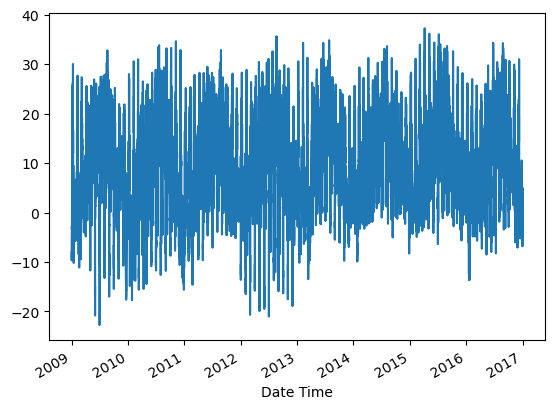

In [14]:
tmp.plot()
plt.show()

In [15]:
'''def df_to_XY(dataframe, windowsize):
    df_to_nparr = dataframe.to_numpy()
    x = []
    y = []
    tx = []
    for e in range(len(df_to_nparr)-windowsize):
        tx.append([e])
        if len(tx) >= windowsize:
            x.append([[tx[e:e+windowsize]]])
            y.append(tx[e+windowsize])
    return x.to_numpy(), y.to_numpy()
    
    ANOTHER APPROACH'''

'def df_to_XY(dataframe, windowsize):\n    df_to_nparr = dataframe.to_numpy()\n    x = []\n    y = []\n    tx = []\n    for e in range(len(df_to_nparr)-windowsize):\n        tx.append([e])\n        if len(tx) >= windowsize:\n            x.append([[tx[e:e+windowsize]]])\n            y.append(tx[e+windowsize])\n    return x.to_numpy(), y.to_numpy()\n    \n    ANOTHER APPROACH'

In [16]:
def df_to_XY(dataframe, windowsize):
    df_to_nparr = dataframe.to_numpy()
    X = []
    Y = []
    for e in range(len(df_to_nparr) - windowsize):
        entry = [[i] for i in df_to_nparr[e:e+windowsize]]
        X.append(entry)
        Y.append(df_to_nparr[e+windowsize])
    return np.array(X), np.array(Y)
        

In [17]:
WINDOWSIZE = 5
X, Y = df_to_XY(tmp, WINDOWSIZE)

## Train-Test Split

In [18]:
X.shape, Y.shape

((70086, 5, 1), (70086,))

In [19]:
X_train, Y_train = X[:60000], Y[:60000]
X_cv, Y_cv = X[60000:65000], Y[60000:65000]
X_test, Y_test = X[65000:], Y[65000:]

In [20]:
X_train.shape, Y_train.shape

((60000, 5, 1), (60000,))

In [21]:
X_cv.shape

(5000, 5, 1)

## Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [23]:
mod1 = Sequential()
mod1.add(InputLayer((5, 1)))
mod1.add(LSTM(64))
mod1.add(Dense(8, 'relu'))
mod1.add(Dense(1, 'linear'))
         
mod1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
bmod = ModelCheckpoint('mod1/', save_best_only=True)
mod1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [25]:
mod1.fit(X_train, Y_train, validation_data=(X_cv, Y_cv), epochs=10, callbacks=[bmod])

Epoch 1/10
1873/1875 [============================>.] - ETA: 0s - loss: 5.7552 - root_mean_squared_error: 2.3990INFO:tensorflow:Assets written to: mod1\assets


INFO:tensorflow:Assets written to: mod1\assets


1875/1875 [==============================] - 12s 5ms/step - loss: 5.7505 - root_mean_squared_error: 2.3980 - val_loss: 0.5007 - val_root_mean_squared_error: 0.7076
Epoch 2/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.6877 - root_mean_squared_error: 0.8293INFO:tensorflow:Assets written to: mod1\assets


INFO:tensorflow:Assets written to: mod1\assets


1875/1875 [==============================] - 12s 6ms/step - loss: 0.6876 - root_mean_squared_error: 0.8292 - val_loss: 0.4926 - val_root_mean_squared_error: 0.7018
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6679 - root_mean_squared_error: 0.8173 - val_loss: 0.5011 - val_root_mean_squared_error: 0.7079
Epoch 4/10
1875/1875 [==============================] - ETA: 0s - loss: 0.6614 - root_mean_squared_error: 0.8132INFO:tensorflow:Assets written to: mod1\assets


INFO:tensorflow:Assets written to: mod1\assets


1875/1875 [==============================] - 11s 6ms/step - loss: 0.6614 - root_mean_squared_error: 0.8132 - val_loss: 0.4866 - val_root_mean_squared_error: 0.6976
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6568 - root_mean_squared_error: 0.8104 - val_loss: 0.4924 - val_root_mean_squared_error: 0.7017
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6527 - root_mean_squared_error: 0.8079 - val_loss: 0.5155 - val_root_mean_squared_error: 0.7180
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6525 - root_mean_squared_error: 0.8078 - val_loss: 0.4920 - val_root_mean_squared_error: 0.7014
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6483 - root_mean_squared_error: 0.8052 - val_loss: 0.5272 - val_root_mean_squared_error: 0.7261
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6425 - root_mean_squared_error: 0.8016 - val_loss: 0.5369 - va

INFO:tensorflow:Assets written to: mod1\assets


1875/1875 [==============================] - 11s 6ms/step - loss: 0.6446 - root_mean_squared_error: 0.8029 - val_loss: 0.4805 - val_root_mean_squared_error: 0.6932


In [26]:
from tensorflow.keras.models import load_model
mod1 = load_model('mod1/')

In [27]:
train_predictions = mod1.predict(X_train).flatten()

1875/1875 [==============================] - 5s 2ms/step


In [28]:
train_results = pd.DataFrame(data={'Predictions':train_predictions, 'Actuals':Y_train})
train_results

,Predictions,Actuals
0,-9.832454,-9.67
1,-9.666286,-9.17
2,-8.721109,-8.10
3,-7.208200,-7.66
4,-7.084429,-7.04
...,...,...
59995,6.074428,6.07
59996,7.052327,9.88
59997,11.927038,13.53
59998,15.324376,15.43


## Plot

## Plot for Train Set

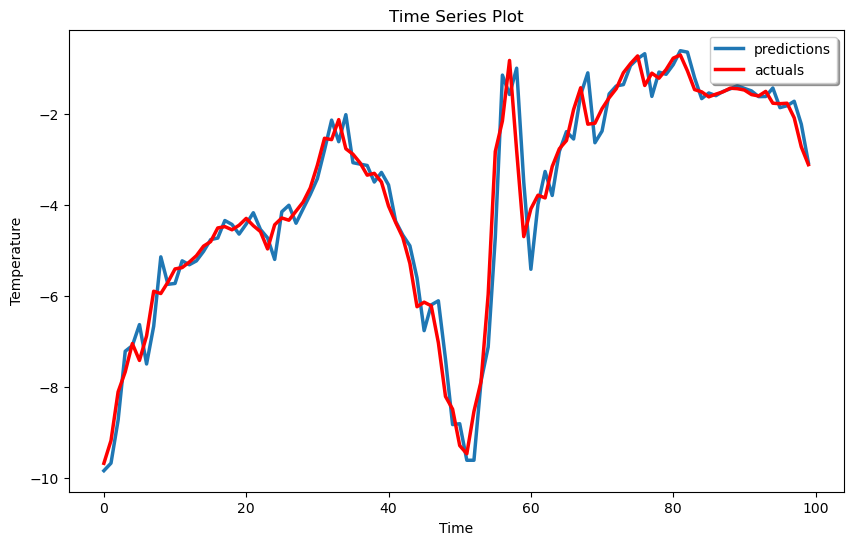

In [29]:
plt.figure(figsize=(10,6))
plt.plot(train_results['Predictions'][:100], linewidth=2.5, label="predictions")
plt.plot(train_results['Actuals'][:100], linewidth=2.5, c="red", label="actuals")
plt.title("Time Series Plot")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend(shadow=True, fancybox=True)
plt.show()

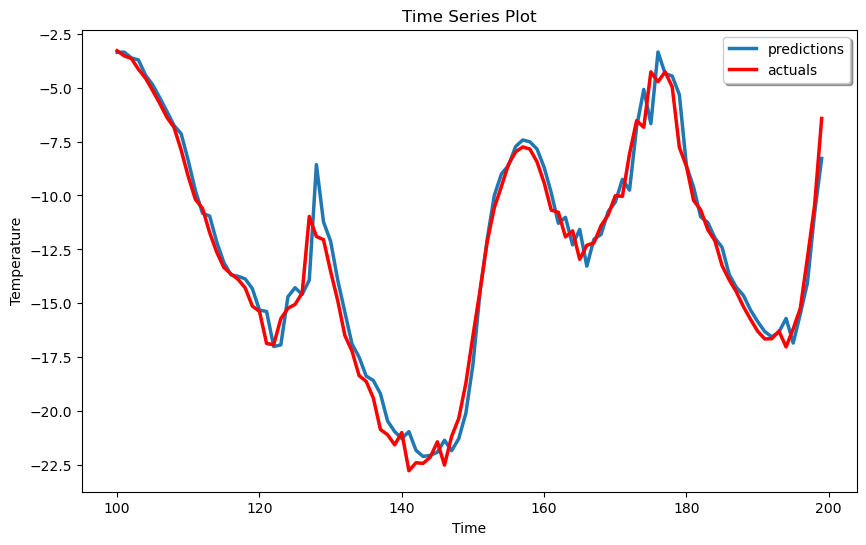

In [30]:
plt.figure(figsize=(10,6))
plt.plot(train_results['Predictions'][100:200], linewidth=2.5, label="predictions")
plt.plot(train_results['Actuals'][100:200], linewidth=2.5, c="red", label="actuals")
plt.title("Time Series Plot")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend(shadow=True, fancybox=True)
plt.show()

In [31]:
cv_predictions = mod1.predict(X_cv).flatten()

157/157 [==============================] - 1s 2ms/step


In [32]:
cv_results = pd.DataFrame(data={'Predictions_cv':cv_predictions, 'Actuals_cv':Y_cv})
cv_results

,Predictions_cv,Actuals_cv
0,15.417228,14.02
1,12.970976,13.67
2,13.042710,12.27
3,11.338698,11.19
4,10.336488,10.85
...,...,...
4995,17.414299,18.27
4996,17.706203,17.85
4997,16.913465,16.65
4998,15.702159,15.85


# Plot for Cross Validation Set

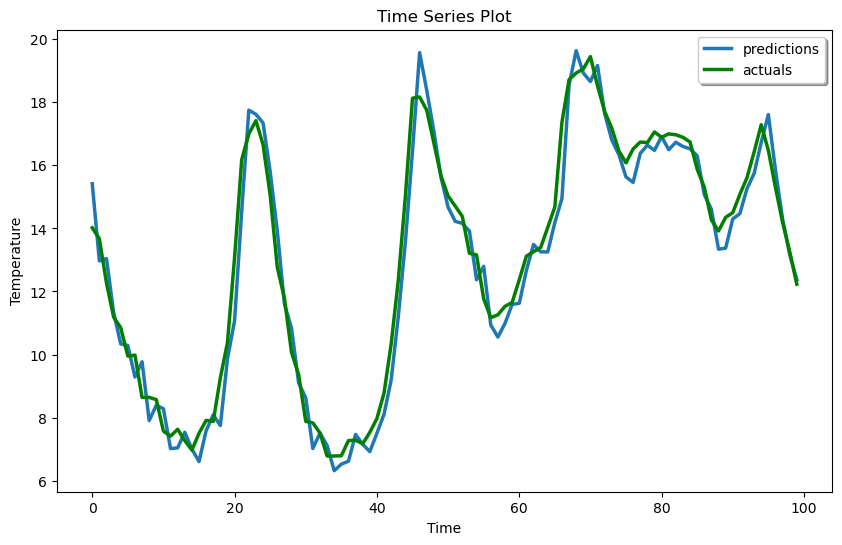

In [33]:
plt.figure(figsize=(10,6))
plt.plot(cv_results['Predictions_cv'][:100], linewidth=2.5, label="predictions")
plt.plot(cv_results['Actuals_cv'][:100], linewidth=2.5, c="green", label="actuals")
plt.title("Time Series Plot")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend(shadow=True, fancybox=True)
plt.show()

## Plot for Test Set

In [34]:
test_predictions = mod1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Predictions_test':test_predictions, 'Actuals_test':Y_test})
test_results

159/159 [==============================] - 0s 2ms/step


,Predictions_test,Actuals_test
0,14.222408,13.99
1,13.077388,13.46
2,12.803817,12.93
3,12.314048,12.43
4,11.896609,12.17
...,...,...
5081,-0.876601,-0.98
5082,-1.511445,-1.40
5083,-1.659057,-2.75
5084,-3.109476,-2.89


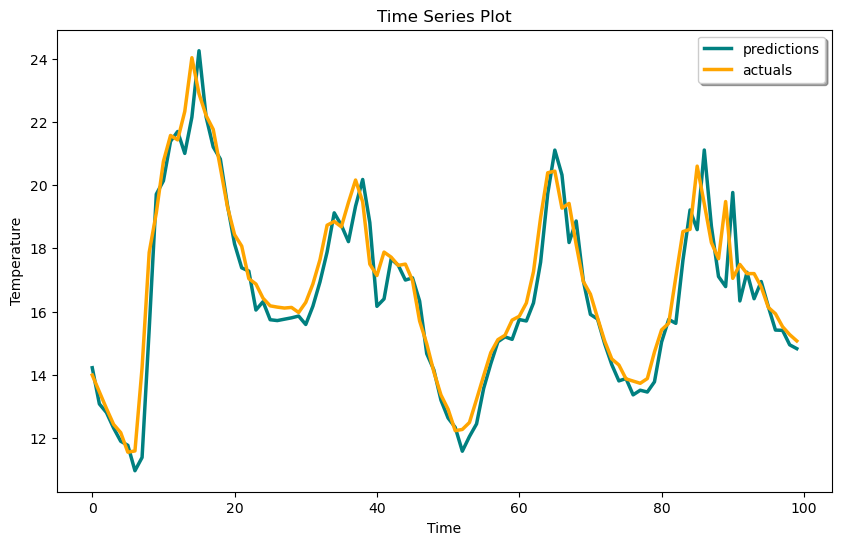

In [38]:
plt.figure(figsize=(10,6))
plt.plot(test_results['Predictions_test'][:100], linewidth=2.5, c="teal", label="predictions")
plt.plot(test_results['Actuals_test'][:100], linewidth=2.5, c="orange", label="actuals")
plt.title("Time Series Plot")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend(shadow=True, fancybox=True)
plt.show()

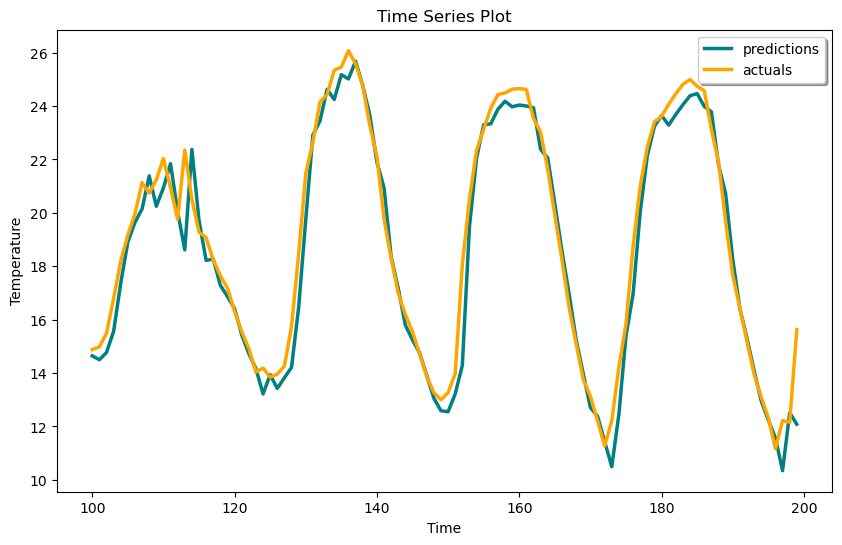

In [36]:
plt.figure(figsize=(10,6))
plt.plot(test_results['Predictions_test'][100:200], linewidth=2.5, c="teal", label="predictions")
plt.plot(test_results['Actuals_test'][100:200], linewidth=2.5, c="orange", label="actuals")
plt.title("Time Series Plot")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend(shadow=True, fancybox=True)
plt.show()